<h3 align="center"><u>ATTEND INFER REPEAT</u></h3> 

![title](AIR/AIR.png)

In [ ]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install Pillow==4.0.0
!pip install PIL
!pip install image
!pip install Pillow
!pip install observations
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

import torch
from PIL import Image

print(torch.__version__)
print(torch.cuda.is_available())

In [0]:
from __future__ import print_function
from observations import multi_mnist
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch
import math
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.normal import Normal

torch.manual_seed(1)
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size=64

def shuffle_data(X, y, seed=None):
    """ Random shuffle of the samples in X and y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

def batch_iterator(X, y=None, batch_size=64):
    """ Simple batch generator """
    n_samples = X.shape[0]
    for i in np.arange(0, n_samples, batch_size):
        begin, end = i, min(i+batch_size, n_samples)
        if y is not None:
            yield X[begin:end], y[begin:end]
        else:
            yield X[begin:end]
            
def fetch_data():
    inpath = 'E:/Docs/Workspace/MS_Thesis_Research/code/data/multi_mnist/'
    (X_train, y_train), (X_test, y_test) = multi_mnist(inpath, max_digits=2, canvas_size=50, seed=42)
    X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)
    X_train /= 255.0
    X_test /= 255.0
    
    X_train, y_train = shuffle_data(X_train, y_train)
    X_test, y_test = shuffle_data(X_test, y_test)
    
    mmnist_train = torch.from_numpy(X_train)
    mmnist_test = torch.from_numpy(X_test)

    return mmnist_train, y_train, mmnist_test, y_test

def data_iter_init():
    X_train, y_train, X_test, y_test = fetch_data()
    train_dset_size, test_dset_size = X_train.size(0), X_test.size(0)
    return batch_iterator(X_train, y_train), batch_iterator(X_test, y_test), train_dset_size, test_dset_size

In [0]:
def expand_z_where(z_where):
    # Takes 3-dimensional vectors, and massages them into 2x3 matrices with elements like so:
    # [s,x,y] -> [[s,0,x],
    #             [0,s,y]]
    n = z_where.size(0)
    expansion_indices = torch.LongTensor([1, 0, 2, 0, 1, 3]).to(device)
    out = torch.cat((torch.zeros([1, 1]).expand(n, 1).to(device), z_where), 1)
    return torch.index_select(out, 1, expansion_indices).view(n, 2, 3)

def object_to_image(z_where, obj):
    n = obj.size(0)
    theta = expand_z_where(z_where)
    grid = F.affine_grid(theta, torch.Size((n, 1, 50, 50)))
    out = F.grid_sample(obj.view(n, 1, 20, 20), grid)
    return out.view(n, 50, 50)


def z_where_inv(z_where):
    # Take a batch of z_where vectors, and compute their "inverse".
    # That is, for each row compute:
    # [s,x,y] -> [1/s,-x/s,-y/s]
    # These are the parameters required to perform the inverse of the
    # spatial transform performed in the generative model.
    n = z_where.size(0)
    out = torch.cat((torch.ones([1, 1]).type_as(z_where).expand(n, 1).to(device), -z_where[:, 1:]), 1)
    out = out / z_where[:, 0:1]
    return out

def image_to_object(z_where, image):
    n = image.size(0)
    theta_inv = expand_z_where(z_where_inv(z_where))
    grid = F.affine_grid(theta_inv, torch.Size((n, 1, 20, 20)))
    out = F.grid_sample(image.view(n, 1, 50, 50), grid)
    return out.view(n, -1)

In [0]:
class latent_code_state(object):
    
    def __init__(self, batch_size, z_pres_dim, z_where_dim, z_what_dim, lstm_state_dim):
        self.z_where_scale_mu = None
        self.z_where_scale_logvar = None
        self.z_where_shift_mu = None
        self.z_where_shift_logvar = None
        self.z_where = torch.zeros(batch_size, z_where_dim).to(device)
        self.z_what_mu = None
        self.z_what_logvar = None
        self.z_what = torch.zeros(batch_size, z_what_dim).to(device)
        self.z_pres_prob = 0.01 * torch.ones(batch_size)
        self.z_pres = torch.ones(batch_size, z_pres_dim).to(device)
        self.h = torch.zeros(batch_size, lstm_state_dim).to(device)
        self.c = torch.zeros(batch_size, lstm_state_dim).to(device)
        self.z_pres_list = []

In [0]:
def log_standard_gaussian(x):
    """
    Evaluates the log pdf of a standard normal distribution at x.
    :param x: point to evaluate
    :return: log N(x|0,I)
    """
    return torch.sum(-0.5 * math.log(2 * math.pi) - x ** 2 / 2, dim=-1)


def log_gaussian(x, mu, log_var):
    """
    Returns the log pdf of a normal distribution parametrised
    by mu and log_var evaluated at x.
    :param x: point to evaluate
    :param mu: mean of distribution
    :param log_var: log variance of distribution
    :return: log N(x|µ,σ)
    """
    log_pdf = - 0.5 * math.log(2 * math.pi) - log_var / 2 - (x - mu)**2 / (2 * torch.exp(log_var))
    return torch.sum(log_pdf, dim=-1)

def compute_kld(z, q_mu, q_logvar):
    """
    Computes the KL-divergence of
    some element z.
    KL(q||p) = -∫ q(z) log [ p(z) / q(z) ]
             = -E[log p(z) - log q(z)]
    :param z: sample from q-distribuion
    :param q_param: (mu, log_var) of the q-distribution
    :param p_param: (mu, log_var) of the p-distribution : Assumed to be  (0,1)
    :return: KL(q||p)
    """

    qz = log_gaussian(z, q_mu, q_logvar)
    pz = log_standard_gaussian(z)
    
    kl = qz - pz

    return kl

====> Epoch: 1 Average loss: 1117.1143
{'z_pres': [0.0, 0.0, 0.0, 1.0], 'z_pres_prob': [0.49, 0.48, 0.49, 0.49]}
{'z_pres': [0.0, 0.0, 0.0, 1.0], 'z_pres_prob': [0.5, 0.49, 0.48, 0.49]}
{'z_pres': [0.0, 0.0, 0.0, 1.0], 'z_pres_prob': [0.5, 0.49, 0.48, 0.5]}


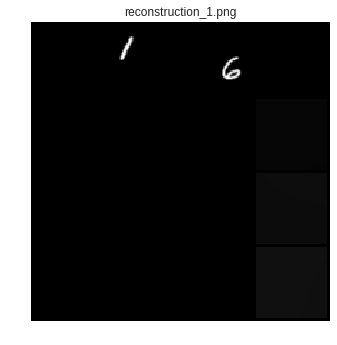

====> Test set loss: 979.8426
====> Epoch: 2 Average loss: 914.5490
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.49, 0.49, 0.49, 0.48]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.47, 0.5, 0.5, 0.48]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.51, 0.5, 0.5, 0.49]}


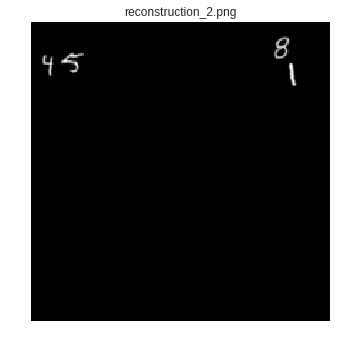

====> Test set loss: 922.6944
====> Epoch: 3 Average loss: 888.7922
{'z_pres': [0.0, 1.0, 1.0, 0.0], 'z_pres_prob': [0.48, 0.49, 0.47, 0.49]}
{'z_pres': [0.0, 0.0, 1.0, 0.0], 'z_pres_prob': [0.48, 0.5, 0.48, 0.5]}
{'z_pres': [0.0, 0.0, 1.0, 0.0], 'z_pres_prob': [0.51, 0.5, 0.54, 0.5]}


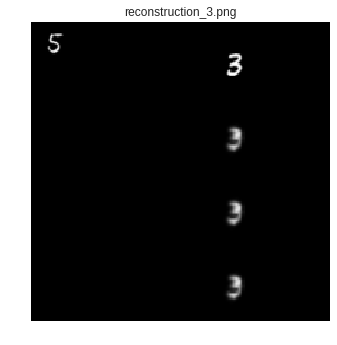

====> Test set loss: 874.7504
====> Epoch: 4 Average loss: 879.5871
{'z_pres': [1.0, 1.0, 0.0, 1.0], 'z_pres_prob': [0.49, 0.49, 0.5, 0.49]}
{'z_pres': [0.0, 1.0, 0.0, 0.0], 'z_pres_prob': [0.49, 0.49, 0.55, 0.49]}
{'z_pres': [0.0, 1.0, 0.0, 0.0], 'z_pres_prob': [0.5, 0.55, 0.53, 0.5]}


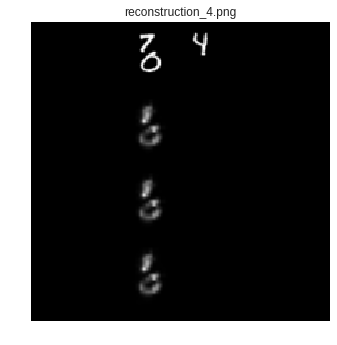

====> Test set loss: 888.8726
====> Epoch: 5 Average loss: 873.3129
{'z_pres': [0.0, 1.0, 0.0, 1.0], 'z_pres_prob': [0.49, 0.48, 0.47, 0.5]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.49, 0.48, 0.49, 0.5]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.49, 0.51, 0.51, 0.5]}


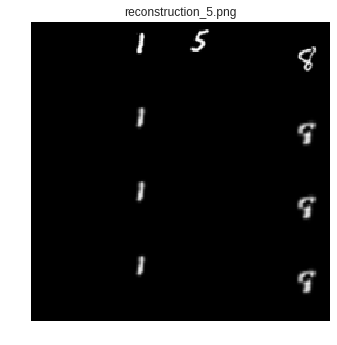

====> Test set loss: 898.7417
====> Epoch: 6 Average loss: 873.8143
{'z_pres': [1.0, 0.0, 0.0, 1.0], 'z_pres_prob': [0.47, 0.49, 0.48, 0.49]}
{'z_pres': [0.0, 0.0, 0.0, 1.0], 'z_pres_prob': [0.52, 0.49, 0.48, 0.53]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.55, 0.49, 0.52, 0.54]}


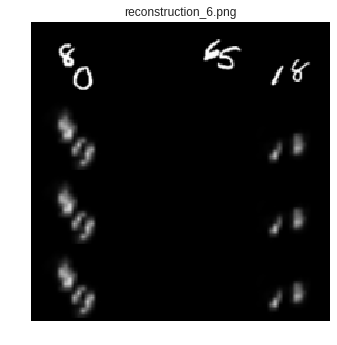

====> Test set loss: 883.5976
====> Epoch: 7 Average loss: 865.2020
{'z_pres': [1.0, 1.0, 0.0, 0.0], 'z_pres_prob': [0.49, 0.49, 0.49, 0.49]}
{'z_pres': [1.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.49, 0.49, 0.53, 0.49]}
{'z_pres': [1.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.56, 0.48, 0.59, 0.49]}


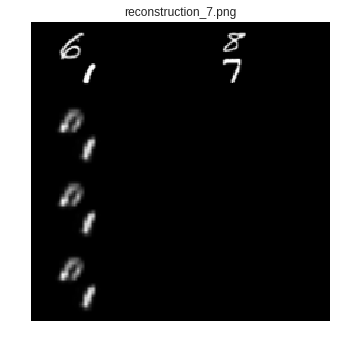

====> Test set loss: 885.3453
====> Epoch: 8 Average loss: 880.3307
{'z_pres': [1.0, 1.0, 1.0, 1.0], 'z_pres_prob': [0.48, 0.47, 0.48, 0.49]}
{'z_pres': [1.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.51, 0.49, 0.56, 0.53]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.54, 0.52, 0.57, 0.55]}


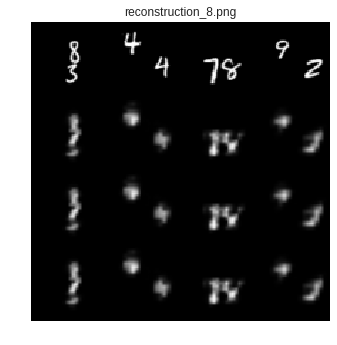

====> Test set loss: 883.6417
====> Epoch: 9 Average loss: 865.9315
{'z_pres': [1.0, 1.0, 0.0, 1.0], 'z_pres_prob': [0.49, 0.49, 0.49, 0.49]}
{'z_pres': [1.0, 0.0, 0.0, 1.0], 'z_pres_prob': [0.49, 0.46, 0.49, 0.49]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.48, 0.54, 0.49, 0.48]}


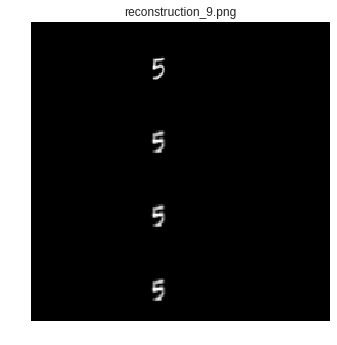

====> Test set loss: 898.9334
====> Epoch: 10 Average loss: 856.8976
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.52, 0.5, 0.48, 0.49]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.51, 0.49, 0.54, 0.5]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.55, 0.48, 0.53, 0.54]}


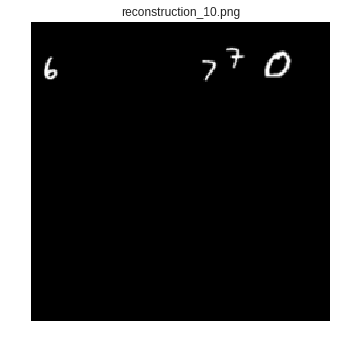

====> Test set loss: 879.5825
====> Epoch: 11 Average loss: 866.3810
{'z_pres': [1.0, 0.0, 1.0, 0.0], 'z_pres_prob': [0.5, 0.49, 0.5, 0.47]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.49, 0.53, 0.49, 0.48]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.47, 0.54, 0.47, 0.51]}


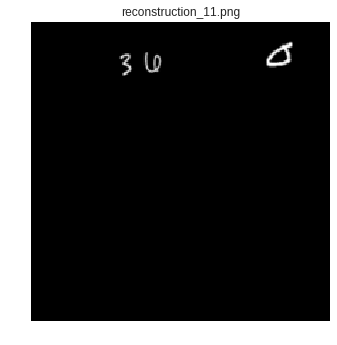

====> Test set loss: 871.2997
====> Epoch: 12 Average loss: 874.6823
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.5, 0.48, 0.48, 0.5]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.51, 0.52, 0.51, 0.49]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.53, 0.51, 0.53, 0.48]}


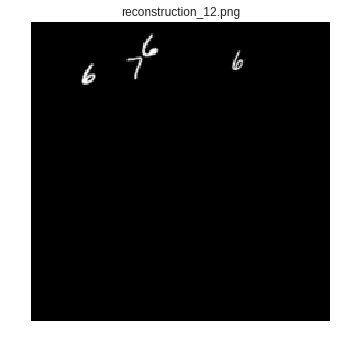

====> Test set loss: 872.2119
====> Epoch: 13 Average loss: 867.6953
{'z_pres': [0.0, 1.0, 1.0, 1.0], 'z_pres_prob': [0.47, 0.46, 0.48, 0.5]}
{'z_pres': [0.0, 0.0, 1.0, 1.0], 'z_pres_prob': [0.49, 0.46, 0.49, 0.55]}
{'z_pres': [0.0, 0.0, 1.0, 1.0], 'z_pres_prob': [0.51, 0.51, 0.53, 0.52]}


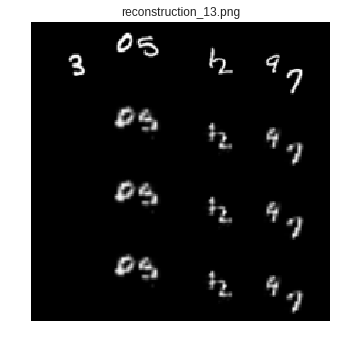

====> Test set loss: 879.5719
====> Epoch: 14 Average loss: 867.8127
{'z_pres': [1.0, 0.0, 1.0, 1.0], 'z_pres_prob': [0.47, 0.5, 0.49, 0.48]}
{'z_pres': [1.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.55, 0.5, 0.47, 0.56]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.5, 0.48, 0.51, 0.52]}


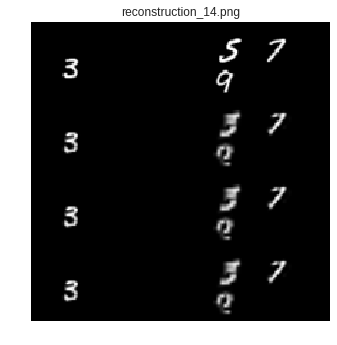

====> Test set loss: 868.0420
====> Epoch: 15 Average loss: 857.2433
{'z_pres': [1.0, 0.0, 0.0, 1.0], 'z_pres_prob': [0.5, 0.47, 0.5, 0.49]}
{'z_pres': [0.0, 0.0, 0.0, 1.0], 'z_pres_prob': [0.5, 0.49, 0.5, 0.55]}
{'z_pres': [0.0, 0.0, 0.0, 1.0], 'z_pres_prob': [0.48, 0.5, 0.49, 0.53]}


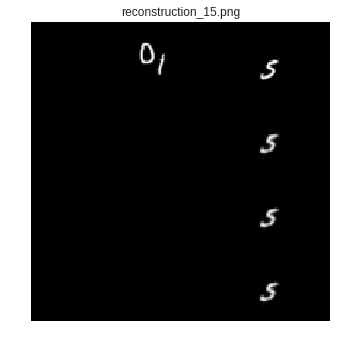

====> Test set loss: 881.6756
====> Epoch: 16 Average loss: 874.7273
{'z_pres': [1.0, 1.0, 0.0, 0.0], 'z_pres_prob': [0.52, 0.49, 0.5, 0.45]}
{'z_pres': [1.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.53, 0.56, 0.57, 0.48]}
{'z_pres': [1.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.55, 0.55, 0.6, 0.51]}


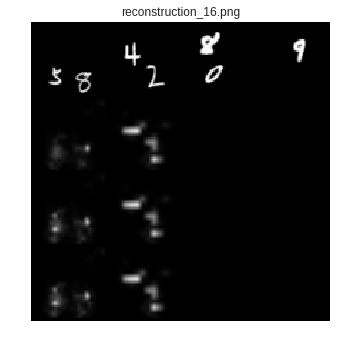

====> Test set loss: 898.3722
====> Epoch: 17 Average loss: 851.9009
{'z_pres': [0.0, 1.0, 0.0, 0.0], 'z_pres_prob': [0.54, 0.52, 0.47, 0.52]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.55, 0.51, 0.48, 0.51]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.53, 0.49, 0.49, 0.49]}


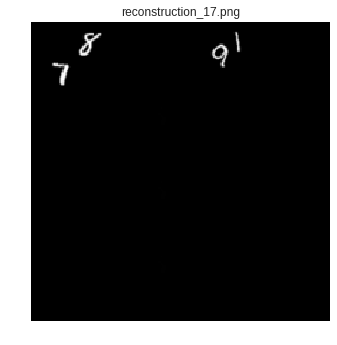

====> Test set loss: 843.3582
====> Epoch: 18 Average loss: 829.1730
{'z_pres': [1.0, 0.0, 1.0, 1.0], 'z_pres_prob': [0.47, 0.51, 0.51, 0.47]}
{'z_pres': [1.0, 0.0, 1.0, 1.0], 'z_pres_prob': [0.46, 0.5, 0.51, 0.48]}
{'z_pres': [1.0, 0.0, 1.0, 0.0], 'z_pres_prob': [0.5, 0.5, 0.49, 0.54]}


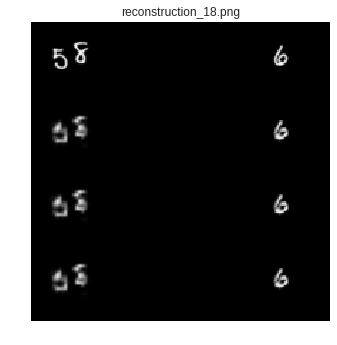

====> Test set loss: 856.6048
====> Epoch: 19 Average loss: 844.0461
{'z_pres': [1.0, 0.0, 0.0, 1.0], 'z_pres_prob': [0.55, 0.51, 0.49, 0.45]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.59, 0.5, 0.5, 0.5]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.54, 0.49, 0.49, 0.49]}


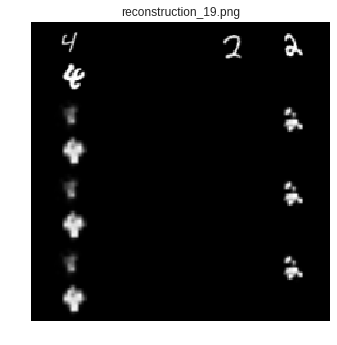

====> Test set loss: 834.7563
====> Epoch: 20 Average loss: 834.0100
{'z_pres': [1.0, 1.0, 1.0, 1.0], 'z_pres_prob': [0.51, 0.51, 0.51, 0.55]}
{'z_pres': [1.0, 1.0, 0.0, 0.0], 'z_pres_prob': [0.51, 0.51, 0.52, 0.51]}
{'z_pres': [0.0, 1.0, 0.0, 0.0], 'z_pres_prob': [0.49, 0.49, 0.51, 0.53]}


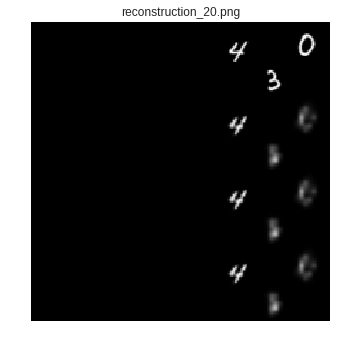

====> Test set loss: 859.1098
====> Epoch: 21 Average loss: 839.8885
{'z_pres': [1.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.52, 0.49, 0.47, 0.52]}
{'z_pres': [1.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.52, 0.6, 0.56, 0.61]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.51, 0.51, 0.47, 0.54]}


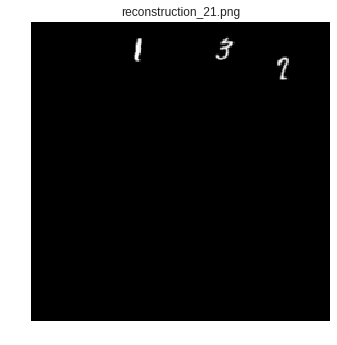

====> Test set loss: 866.7983
====> Epoch: 22 Average loss: 836.8336
{'z_pres': [1.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.51, 0.5, 0.52, 0.52]}
{'z_pres': [1.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.65, 0.54, 0.51, 0.64]}
{'z_pres': [1.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.52, 0.49, 0.51, 0.53]}


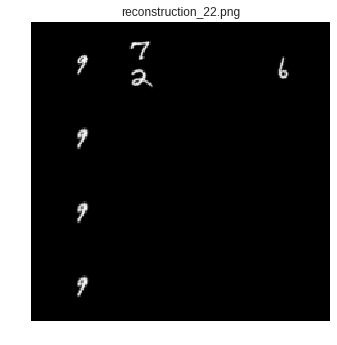

====> Test set loss: 824.5704
====> Epoch: 23 Average loss: 826.8020
{'z_pres': [1.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.52, 0.52, 0.51, 0.48]}
{'z_pres': [1.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.52, 0.51, 0.6, 0.58]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.5, 0.5, 0.5, 0.5]}


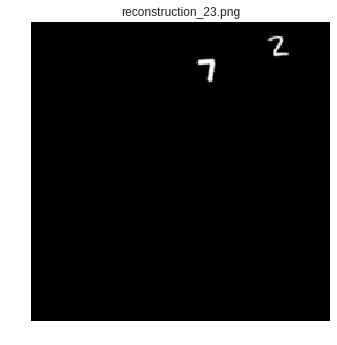

====> Test set loss: 845.7239
====> Epoch: 24 Average loss: 831.8890
{'z_pres': [1.0, 0.0, 0.0, 1.0], 'z_pres_prob': [0.43, 0.58, 0.47, 0.52]}
{'z_pres': [0.0, 0.0, 0.0, 1.0], 'z_pres_prob': [0.58, 0.55, 0.6, 0.52]}
{'z_pres': [0.0, 0.0, 0.0, 1.0], 'z_pres_prob': [0.51, 0.55, 0.52, 0.51]}


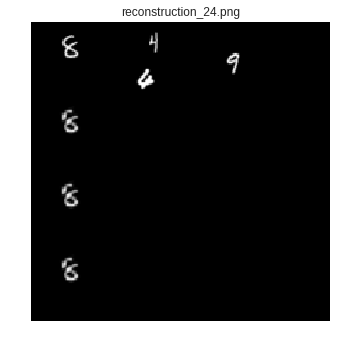

====> Test set loss: 829.3797
====> Epoch: 25 Average loss: 831.2367
{'z_pres': [0.0, 0.0, 1.0, 1.0], 'z_pres_prob': [0.52, 0.5, 0.5, 0.52]}
{'z_pres': [0.0, 0.0, 1.0, 1.0], 'z_pres_prob': [0.52, 0.59, 0.56, 0.52]}
{'z_pres': [0.0, 0.0, 1.0, 1.0], 'z_pres_prob': [0.51, 0.52, 0.48, 0.51]}


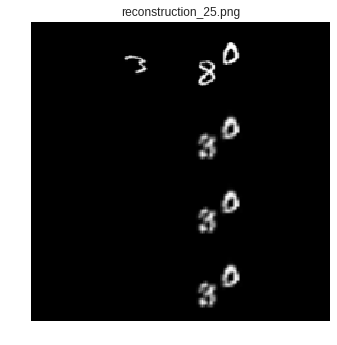

====> Test set loss: 856.3550
====> Epoch: 26 Average loss: 839.7024
{'z_pres': [0.0, 0.0, 0.0, 1.0], 'z_pres_prob': [0.52, 0.49, 0.52, 0.52]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.58, 0.52, 0.51, 0.51]}
{'z_pres': [0.0, 0.0, 0.0, 0.0], 'z_pres_prob': [0.49, 0.48, 0.51, 0.51]}


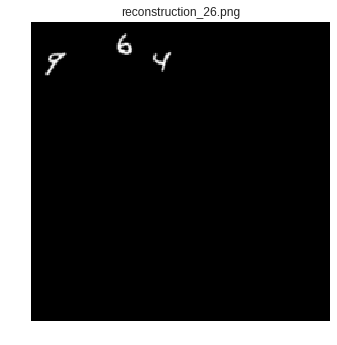

====> Test set loss: 849.4587


In [0]:
class AIR(nn.Module):
    def __init__(self):
        super(AIR, self).__init__()
        self.inp_dim = 2500
        self.obj_dim = 400
        self.obj_hidden_dim = 200
        self.z_where_dim = 3
        self.z_what_dim = 50
        self.z_pres_dim = 1
        self.lstm_state_dim = 256
        
        self.rnn = nn.LSTMCell(self.inp_dim + self.z_what_dim + self.z_where_dim + self.z_pres_dim,
                               self.lstm_state_dim)
        self.latent_pred = nn.Linear(self.lstm_state_dim,
                                     self.z_pres_dim + self.z_where_dim + self.z_where_dim)
        
        # Encoder layers
        self.fc1 = nn.Linear(self.obj_dim, self.obj_hidden_dim)
        self.fc2 = nn.Linear(self.obj_hidden_dim, 2 * self.z_what_dim)
        
        # Decoder layers
        self.fc3 = nn.Linear(self.z_what_dim, self.obj_hidden_dim)
        self.fc4 = nn.Linear(self.obj_hidden_dim, self.obj_dim)
    
    def infer_net(self, x, prev):
        rnn_ip = torch.cat((x, prev.z_where, prev.z_what, prev.z_pres), 1)
        h, c = self.rnn(rnn_ip, (prev.h, prev.c))
        
        z_code = self.latent_pred(h)
        
        z_pres_prob = F.sigmoid(z_code[:, 0:1])
        z_pres = Bernoulli(z_pres_prob * prev.z_pres).sample()
        
        z_where_mu = z_code[:, 1:4]
        z_where_logvar = z_code[:, 4:]
        z_where = self.reparameterize(z_where_mu, z_where_logvar)
        
        x_att = image_to_object(z_where, x)   
        
        h_enc = F.relu(self.fc1(x_att))
        z_what_code = self.fc2(h_enc)
        
        prev.z_what_mu = z_what_code[:, :50]
        prev.z_what_logvar = z_what_code[:, 50:]
        prev.z_what = self.reparameterize(z_what_code[:, :50], z_what_code[:, 50:])
        
        prev.z_where_mu = z_where_mu
        prev.z_where_logvar = z_where_logvar
        prev.z_where = z_where
        
        prev.z_pres = z_pres
        prev.z_pres_list.append({'z_pres_prob':[round(i.item(), 2) for i in z_pres_prob],\
                                 'z_pres':[round(i.item(), 2) for i in z_pres]})
        prev.h = h
        prev.c = c
        return prev


    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def generator_net(self, recon_x, curr):
        
        h_dec = F.relu(self.fc3(curr.z_what))
        y_att = F.sigmoid(self.fc4(h_dec))
        
        y = object_to_image(curr.z_where, y_att).view(-1, 2500)
        
        recon_x = recon_x + y * curr.z_pres.view(-1, 1)
        
        return recon_x

    def forward(self, x):
        
        N = 3
        code = latent_code_state(x.size(0), self.z_pres_dim, self.z_where_dim, self.z_what_dim, self.lstm_state_dim)
        recon_x = torch.zeros_like(x.view(-1, 2500))
        
        for i in range(N):
            
            code = self.infer_net(x.view(-1, 2500), code)
            
            recon_x = self.generator_net(recon_x, code).view(-1, 2500)
        
        kld_loss = compute_kld(code.z_what, code.z_what_mu, code.z_what_logvar) + \
                   compute_kld(code.z_where, code.z_where_mu, code.z_where_logvar)

        return recon_x, code, kld_loss

    def generate_sample(self, x):

        N = 3
        code = latent_code_state(x.size(0), self.z_pres_dim, self.z_where_dim,
                                 self.z_what_dim, self.lstm_state_dim)
        recon_x = torch.zeros_like(x.view(-1, 2500))
        recon_stages = torch.zeros(N, recon_x.size(0), 2500)
        
        for i in range(N):
            
            code = self.infer_net(x.view(-1, 2500), code)
            recon_x = self.generator_net(recon_x, code).view(-1, 2500)
            recon_stages[i] = recon_x
        
        [print(i) for i in code.z_pres_list]
        return recon_stages
    

model = AIR().to(device)
#model.state_dict = torch.load('air_0.pt')
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction loss
def loss_function(recon_x, x):
    BCE = F.binary_cross_entropy(recon_x.clamp(min=0., max=1.), x.view(-1, 2500), size_average=False)
    return BCE

def train(epoch, train_iter, train_dset_size):
    
    model.train()
    log_interval = 10
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_iter):
        data = data.to(device)
        optimizer.zero_grad()
        batch_loss = 0
        
        x = data.view(-1, 2500)
        recon_x, code, kld = model(x)
        batch_loss = loss_function(recon_x, x) + kld.sum()

        batch_loss.backward()
        train_loss += batch_loss.item()
        optimizer.step()
        '''
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), train_dset_size,
                100. * batch_idx / (train_dset_size//batch_size),
                batch_loss.item() / len(data)))
        '''
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / train_dset_size))


def test(epoch, test_iter, test_dset_size):
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        for i, (data, _) in enumerate(test_iter):
            data = data.to(device)
            
            batch_loss = 0
            x = data.view(-1, 2500)
            recon_x, code, kld = model(x)
            batch_loss = loss_function(recon_x, x).item() + kld.sum().item()
                
            test_loss += batch_loss
            if i == 0:
                n = min(data.size(0), 4)
                N = 3

                x = data[:n].view(-1, 2500)
                recon_x = model.generate_sample(x)
                recon_batch = recon_x.view(N, n, 1, 2500)
                
                comparison = torch.cat([data[:n].view(-1, 1, 50, 50),
                                        recon_batch[0].view(-1, 1, 50, 50),
                                        recon_batch[1].view(-1, 1, 50, 50),
                                        recon_batch[2].view(-1, 1, 50, 50)])
                
                save_image(comparison.cpu(),
                           'reconstruction_' + str(epoch) + '.png', nrow=n)

                img = mpimg.imread('reconstruction_' + str(epoch) + '.png')
                plt.axis('off')
                plt.title('reconstruction_' + str(epoch) + '.png')
                plt.imshow(img)
                plt.show()

    test_loss /= test_dset_size
    print('====> Test set loss: {:.4f}'.format(test_loss))

epochs = 1000
for epoch in range(1, epochs + 1):
    train_iter, test_iter, train_dset_size, test_dset_size = data_iter_init()
    train(epoch, train_iter, train_dset_size)
    test(epoch, test_iter, test_dset_size)